In [ ]:
# %% [markdown]
"""
# Exercise 9: Sentiment Classification with an MLP

In this notebook, we will:
1. Load and inspect the IMDB sentiment dataset (train/test) provided in the local `aclImdb/` directory.
2. Preprocess texts and extract features (e.g., TF-IDF).
3. Define an MLP classifier with dropout for regularization.
4. Train and evaluate the model.

We structure the code using Python classes, each explained in the Markdown cells that precede them.
"""

# %% [markdown]
"""
## 0. Setup and Data Inspection

You have your `aclImdb/` folder at a custom path. In Colab, first mount your Google Drive (or upload the folder) and set `data_root` accordingly.

For example, if you mount your drive at `/content/drive`, and the data is in `Drive/MyDrive/aclImdb`, set:
```python
# In Colab:
from google.colab import drive
drive.mount('/content/drive')

data_root = '/content/drive/MyDrive/aclImdb'
```

Then run the cell to verify the folder and inspect file counts.
"""
# %%

"\n## 0. Setup and Data Inspection\n\nYou have your `aclImdb/` folder at a custom path. In Colab, first mount your Google Drive (or upload the folder) and set `data_root` accordingly.\n\nFor example, if you mount your drive at `/content/drive`, and the data is in `Drive/MyDrive/aclImdb`, set:\n```python\n# In Colab:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\ndata_root = '/content/drive/MyDrive/aclImdb'\n```\n\nThen run the cell to verify the folder and inspect file counts.\n"

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import tarfile
from pathlib import Path
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving aclImdb_v1.tar.gz to aclImdb_v1.tar.gz


In [ ]:
!ls -lh

total 81M
-rw-r--r-- 1 root root  81M May 12 11:48 aclImdb_v1.tar.gz
-rw-r--r-- 1 root root   22 May 12 11:33 aclImdb.zip
drwxr-xr-x 1 root root 4.0K May  8 13:38 sample_data


In [ ]:
!tar -xvzf aclImdb_v1.tar.gz -C /content

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [ ]:
!ls /content/aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
# TODO: Update this path to your actual ACL IMDb folder location
# Example for Colab with Google Drive mounted:
# data_root = '/content/drive/MyDrive/aclImdb'
# Or if you uploaded the folder directly to Colab working dir:
data_root = '/content/aclImdb'

# Verify the top-level folder
if not os.path.isdir(data_root):
    raise FileNotFoundError(f"Data folder '{data_root}' not found.")
print("OK — found", data_root)


OK — found /content/aclImdb


In [ ]:
# Inspect directory structure and counts
for split in ['train', 'test']:
    print(f"Split: {split}")
    for label in ['pos', 'neg', 'unsup']:
        folder = Path(data_root) / split / label
        if folder.exists():
            count = len(list(folder.glob('*.txt')))
            print(f"  {label:5s}: {count} files")

Split: train
  pos  : 12500 files
  neg  : 12500 files
  unsup: 50000 files
Split: test
  pos  : 12500 files
  neg  : 12500 files


In [ ]:
# Print a few sample filenames and contents from test
print("Sample negative test reviews:")
neg_folder = Path(data_root) / 'test' / 'neg'
neg_test = list(neg_folder.glob('*.txt'))[:2]
for path in neg_test:
    print(f"- {path.name}")
    print(path.read_text()[:200].replace('\n', ' '), '...')

print("Sample positive test reviews:")
pos_folder = Path(data_root) / 'test' / 'pos'
pos_test = list(pos_folder.glob('*.txt'))[:2]
for path in pos_test:
    print(f"- {path.name}")
    print(path.read_text()[:200].replace('\n', ' '), '...')

Sample negative test reviews:
- 2622_2.txt
I watched the first few episodes a short while back and felt I couldn't take it anymore. The horrible looking fight scenes are the worst I've ever scene in my life. About one-third of each episode is  ...
- 7744_1.txt
Kathy Ireland: the body of a goddess, the face of an angel, the voice of a Smurf.<br /><br />And the acting talent of a shovel full of calcite. If you don't believe me, check this out: "Alien from L.A ...
Sample positive test reviews:
- 10974_8.txt
No bullets, no secret agents, a story that is entertaining, funny, and believable. Met some of the producers/actors in this film at the theater. They seemed as interesting in person as their character ...
- 10792_8.txt
I have never been a great fan of Oliver Stone, often because I have found his films to be forced, preachy and generally flawed. The two Stone films I truly like are JFK and Talk Radio, yet Talk Radio  ...


In [ ]:
# %% [markdown]
"""
## 1. Dataset loader


We define a `IMDBDataset` class that:
- Reads raw text files from `train/pos`, `train/neg`, `test/pos`, `test/neg` directories.
- Uses a vectorizer (e.g., TF-IDF) to convert texts into feature vectors.
- Returns `(features, label)` pairs as PyTorch tensors.
"""
# %%

'\n## 1. Dataset loader\n\n\nWe define a `IMDBDataset` class that:\n- Reads raw text files from `train/pos`, `train/neg`, `test/pos`, `test/neg` directories.\n- Uses a vectorizer (e.g., TF-IDF) to convert texts into feature vectors.\n- Returns `(features, label)` pairs as PyTorch tensors.\n'

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data_dir, split, vectorizer):
        """
        data_dir: root folder 'aclImdb'
        split: 'train' or 'test'
        vectorizer: fitted TfidfVectorizer or CountVectorizer
        """
        self.texts, self.labels = [], []
        folder_root = Path(data_dir) / split
        for label in ['pos', 'neg']:
            idx = 1 if label == 'pos' else 0
            for txt_path in (folder_root / label).glob('*.txt'):
                self.texts.append(txt_path.read_text())
                self.labels.append(idx)

        # Convert texts to feature matrix
        X = vectorizer.transform(self.texts)
        self.features = X  # sparse matrix
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx].toarray().squeeze(), dtype=torch.float32)
        y = self.labels[idx]
        return x, y

In [ ]:
# %% [markdown]
"""
## 2. Feature extraction

We use scikit-learn's `TfidfVectorizer` to convert raw texts into TF-IDF feature vectors. We'll fit on the training texts only, then transform both train and test splits.
"""
# %%

"\n## 2. Feature extraction\n\nWe use scikit-learn's `TfidfVectorizer` to convert raw texts into TF-IDF feature vectors. We'll fit on the training texts only, then transform both train and test splits.\n"

In [ ]:
# Both are good ways. The first one is easier to read :D

In [ ]:
# Prepare the vectorizer fit on training data
train_files = (
    list((Path(data_root) / 'train' / 'pos').glob('*.txt'))
  + list((Path(data_root) / 'train' / 'neg').glob('*.txt'))
)
train_texts = [p.read_text() for p in train_files]
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_texts)
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}\n")

# Create dataset objects
train_dataset = IMDBDataset(data_root, 'train', vectorizer)
test_dataset  = IMDBDataset(data_root, 'test',  vectorizer)

print(f"Train examples: {len(train_dataset)}")
print(f"Test examples:  {len(test_dataset)}")

Vocabulary size: 5000

Train examples: 25000
Test examples:  25000


In [ ]:
# 1) build the list of train files
pos_folder = Path(data_root) / 'train' / 'pos'
neg_folder = Path(data_root) / 'train' / 'neg'

train_files = list(pos_folder.glob('*.txt')) + list(neg_folder.glob('*.txt'))

# 2) read in the raw texts
train_texts = [p.read_text(encoding='utf-8') for p in train_files]

# 3) fit your TF–IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_texts)
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}\n")

# 4) now create your datasets
train_dataset = IMDBDataset(data_root, 'train', vectorizer)
test_dataset  = IMDBDataset(data_root, 'test',  vectorizer)

print(f"Train examples: {len(train_dataset)}")
print(f"Test examples:  {len(test_dataset)}")

Vocabulary size: 5000

Train examples: 25000
Test examples:  25000


In [ ]:
## STEP 1.
# 1) Build train/dev/test splits and TF–IDF feature matrices
# a) List all positive & negative training files
pos_files = list((Path(data_root)/'train'/'pos').glob('*.txt'))
neg_files = list((Path(data_root)/'train'/'neg').glob('*.txt'))
all_files = pos_files + neg_files
# Create corresponding labels: 1 for pos, 0 for neg
all_labels = np.array([1]*len(pos_files) + [0]*len(neg_files))

# b) Read raw text from each file
all_texts = [p.read_text(encoding='utf-8') for p in all_files]

In [ ]:
# c) Split into train/dev (80/20), stratified to keep class balance
X_train_texts, X_dev_texts, y_train, y_dev = train_test_split(
    all_texts, all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

# d) Fit TF–IDF on training texts only, then transform train & dev
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_texts)
X_dev   = vectorizer.transform(X_dev_texts)

In [ ]:
# e) Prepare the test set in the same way
pos_test = list((Path(data_root)/'test'/'pos').glob('*.txt'))
neg_test = list((Path(data_root)/'test'/'neg').glob('*.txt'))
X_test_texts = [p.read_text(encoding='utf-8') for p in (pos_test + neg_test)]
y_test       = np.array([1]*len(pos_test) + [0]*len(neg_test))
X_test = vectorizer.transform(X_test_texts)

# Keras likes dense arrays, so convert sparse → dense
X_train = X_train.toarray()
X_dev   = X_dev.toarray()
X_test  = X_test.toarray()

print("Shapes:", X_train.shape, X_dev.shape, X_test.shape)
print("Label counts:", np.bincount(y_train),
      np.bincount(y_dev), np.bincount(y_test))

Shapes: (20000, 5000) (5000, 5000) (25000, 5000)
Label counts: [10000 10000] [2500 2500] [12500 12500]


In [ ]:
## STEP 2.
input_dim = X_train.shape[1]  # = 5000 features

model = Sequential([
    Input(shape=(input_dim,)),    # explicit Input layer
    Dense(512, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),  # add small L2
    Dropout(0.5),                 # 50% dropout for regularization
    Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # single‐unit output for binary class
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,097 (10.27 MB)

 Trainable params: 2,692,097 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 - 6s - 10ms/step - accuracy: 0.8496 - loss: 0.4303 - val_accuracy: 0.8734 - val_loss: 0.3904
Epoch 2/20
625/625 - 7s - 12ms/step - accuracy: 0.9087 - loss: 0.3402 - val_accuracy: 0.8778 - val_loss: 0.4143
Epoch 3/20
625/625 - 2s - 3ms/step - accuracy: 0.9252 - loss: 0.3236 - val_accuracy: 0.8624 - val_loss: 0.4606
Epoch 4/20
625/625 - 3s - 4ms/step - accuracy: 0.9387 - loss: 0.3023 - val_accuracy: 0.8698 - val_loss: 0.4721


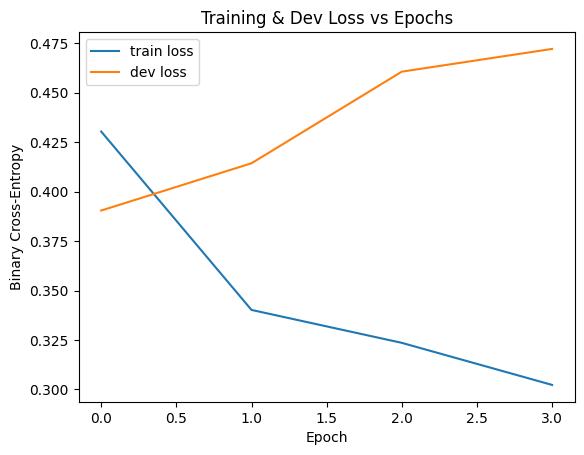

In [ ]:
## STEP 3.
# 3) Train with EarlyStopping on validation loss
es = EarlyStopping(
    monitor='val_loss',
    patience=3,      # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    epochs=20,       # allow up to 20 epochs
    batch_size=32,
    callbacks=[es],
    verbose=2
)

plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],  label='dev loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')
plt.legend()
plt.title('Training & Dev Loss vs Epochs')
plt.show()

In [ ]:
## STEP 4.
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [ ]:
def evaluate(name, y_true, y_proba):
    """Print classification report + PR AUC + macro-P/R/F1."""
    y_pred = (y_proba >= 0.5).astype(int)
    print(f"=== {name} ===")
    print(classification_report(
        y_true, y_pred, target_names=['neg','pos'], digits=4
    ))
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR AUC: {pr_auc:.4f}")
    print()

In [ ]:
# MLP on train/dev/test
for split_name, X_split, y_split in [
    ('Train', X_train, y_train),
    ('Dev',   X_dev,   y_dev),
    ('Test',  X_test,  y_test),
]:
    y_proba = model.predict(X_split).ravel()
    evaluate(f"MLP {split_name}", y_split, y_proba)

# Majority‐class baseline for test
majority_proba = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
evaluate("Majority baseline (Test)", y_test, majority_proba)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
=== MLP Train ===
              precision    recall  f1-score   support

         neg     0.9135    0.9536    0.9331     10000
         pos     0.9515    0.9097    0.9301     10000

    accuracy                         0.9316     20000
   macro avg     0.9325    0.9316    0.9316     20000
weighted avg     0.9325    0.9316    0.9316     20000

PR AUC: 0.9819

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
=== MLP Dev ===
              precision    recall  f1-score   support

         neg     0.8511    0.9052    0.8773      2500
         pos     0.8988    0.8416    0.8692      2500

    accuracy                         0.8734      5000
   macro avg     0.8749    0.8734    0.8733      5000
weighted avg     0.8749    0.8734    0.8733      5000

PR AUC: 0.9500

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
=== MLP Test ===
              precision    recall  f1-score   support

         neg     0.8418    0.9146    0.8767     12500
         pos     0.9065    0.82

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
